____
# Multi-Layer Perceptron - MNIST Image Recognition
_____

In this notebook, we will build out a Multi Layer Perceptron model to try to classify hand written digits using TensorFlow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Data
_____________
We will be using the famous MNIST data set of [handwritten digits](http://yann.lecun.com/exdb/mnist/). 

The images which we will be working with are black and white images of size 28 x 28 pixels, or 784 pixels total. Our features will be the pixel values for each pixel. Either the pixel is "white" (blank with a 0), or there is some pixel value. 

We will try to correctly predict what number is written down based solely on the image data in the form of an array

**Get the data**

In [2]:
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Data Format

The data is stored in a vector format, although the original data was a 2-dimensional matrix with values representing how much pigment was at a certain location.

In [3]:
print("Size of:" )
print("- Training-set:{}".format(mnist.train.num_examples))
print("- Test-set:{}".format(mnist.test.num_examples))

Size of:
- Training-set:55000
- Test-set:10000


In [4]:
# how is data formatted? 
print('Shape of each image is: ', mnist.train.images[0].shape)

print('Label data is formatted: ', mnist.train.labels[0])
print('Shape of each label is: ', mnist.train.labels[0].shape)

Shape of each image is:  (784,)
Label data is formatted:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape of each label is:  (10,)


Each Image is an array has 784 items. Each item representing levels of grey of each pixel. Originally images are 28x28 pixel box. 

Each label data has 10 items, each item representing a number from 0 to 9. 

### Helper-function

I think I'll make two help-function here.
1. Image Plotting Function - This is helper function to plot 9 images on 3x3 grid, with the true and predicted classes below each images. 
2. Returning Number function - This takes the label data and returns the corresponding number.

In [5]:
def return_number(array):
    return list(array).index(1)

def plot_images(images, true_class, pred_class=None):
    assert len(images) == len(true_class) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28,28)), cmap='binary')

        # Show true and predicted classes.
        if pred_class is None:
            xlabel = "True: {0}".format(return_number(true_class[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(return_number(true_class[i]), return_number(cls_pred[i]))

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    return

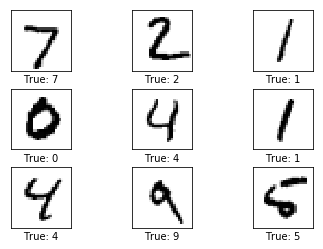

In [6]:
# Get the first images from the test-set.
images = mnist.test.images[0:9]

# Get the true classes for those images.
true_class = mnist.test.labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, true_class=true_class)

### Define Parameters
Parameters
* Learning Rate - How quickly to adjust the cost function.
* Training Epochs - How many training cycles to go through
* Batch Size - Size of the 'batches' of training data

Network Parameters
* n_hidden_1 - Number of neurons in the 1st layer
* n_hidden_2 - Number of neurons in the 2nd layer
* n_input - Input shape (not img shape: 28*28)
* n_classes - Total number of classess (0 to 9 numeric numbers)
* n_samples - Number of samples

In [7]:
# Parameters
learning_rate = 0.001
training_epochs = 40
batch_size = 100

# Network Parameters
n_hidden_1 = 256 
n_hidden_2 = 256
n_input = 784
n_classes = 10
n_samples = mnist.train.num_examples

## MultiLayer Model
____________

Now let's build multi-layer perceptron model.
This is the process we will follow!

1. We will send the **input data array to the first hidden layer.**
2. The data will get **weight attached to it** between layers and then sent to a node to **undergo an activation function (along with a Bias).** We will use [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. (which essentially returns either x or zero).
3. The data will move to second hidden layer and undergo the same process. 
4. Once the transformed data has reached the output layer, we will use a linear activation function with matrix multiplication.
5. And then we will make cost and accuracy evaluation. 

We will **apply an optimzation function to lower the error.** We will use the [Adam Optimizer](http://arxiv.org/pdf/1412.6980v8.pdf).

Let's START!

In [8]:
# function for multi-layer perceptron
def multilayer_perceptron(x, weights, biases):
    '''
    x : placeholder for Data Input
    weights: dictionary of weights
    biases: dicitionary of biases
    '''
    
    # First Hidden layer with ReLU activation
    # can be considered two steps
    # step1 : x * wieght + biases
    # step2 : ReLU(x * weight + biases) -> ReLU(x) : f(x) = max(0,x)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Second Hidden layer with ReLU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Last Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return out_layer

### Weights and Bias

We need to create two dictionaries containing the weight and bias objects for the model. We will use **tf.variable** to create the *variable*. 

tf.variable is a modificable tensor that lives in TensorFlow's graph of interactive operations. So it can be used and be modified by the computation. Documentation says:
- A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.
- The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
We will use random_normal method to create the random values for our weights and biases.

In [9]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

In [10]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [11]:
# set placeholder for x and y
x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('float', [None, n_classes])

In [12]:
# Construct model - multilayer perceptron
pred = multilayer_perceptron(x, weights, biases)

## Cost and Optimization Functions

I'll use Tensorflow's built-in functions for cost and optimizer functions. 

In [13]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

## Training the Model
____

In [14]:
# Launch the session
sess = tf.InteractiveSession()

# Now initialize all those tf.Variable objects we created earlier. 
# This will be the first thing we run when training our model:
init = tf.global_variables_initializer()

sess.run(init)

costs = []

# Training Epochs
# Essentially the max amount of loops possible before we stop
# May stop earlier if cost/loss limit was set
for epoch in range(training_epochs):

    # Start with cost = 0.0, we are trying to minimize this
    avg_cost = 0.0

    # Convert total number of batches to integer
    total_batch = int(n_samples/batch_size)

    # Loop over all batches
    for i in range(total_batch):

        # Grab the next batch of training data and labels
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # Feed dictionary for optimization and loss value
        # Returns a tuple, but we only need 'c' the cost
        # So we set an underscore as a "throwaway"
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost += c / total_batch

    print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))
    costs.append(avg_cost)

print("Model has completed {} Epochs of Training".format(training_epochs))

Epoch: 1 cost=176.9226
Epoch: 2 cost=43.1191
Epoch: 3 cost=27.2498
Epoch: 4 cost=19.1290
Epoch: 5 cost=13.7459
Epoch: 6 cost=10.4267
Epoch: 7 cost=7.7401
Epoch: 8 cost=5.8667
Epoch: 9 cost=4.4164
Epoch: 10 cost=3.2253
Epoch: 11 cost=2.4565
Epoch: 12 cost=1.8675
Epoch: 13 cost=1.4507
Epoch: 14 cost=1.1135
Epoch: 15 cost=0.8999
Epoch: 16 cost=0.6751
Epoch: 17 cost=0.6497
Epoch: 18 cost=0.6393
Epoch: 19 cost=0.4474
Epoch: 20 cost=0.4985
Epoch: 21 cost=0.5098
Epoch: 22 cost=0.4594
Epoch: 23 cost=0.3394
Epoch: 24 cost=0.3141
Epoch: 25 cost=0.3039
Epoch: 26 cost=0.2701
Epoch: 27 cost=0.3644
Epoch: 28 cost=0.3906
Epoch: 29 cost=0.3071
Epoch: 30 cost=0.2678
Epoch: 31 cost=0.2418
Epoch: 32 cost=0.2470
Epoch: 33 cost=0.2575
Epoch: 34 cost=0.3217
Epoch: 35 cost=0.2486
Epoch: 36 cost=0.2105
Epoch: 37 cost=0.3257
Epoch: 38 cost=0.1821
Epoch: 39 cost=0.2067
Epoch: 40 cost=0.2587
Model has completed 40 Epochs of Training


## Model Evaluations
_____

Let's take a look at loss over time.

Text(0,0.5,'Cost')

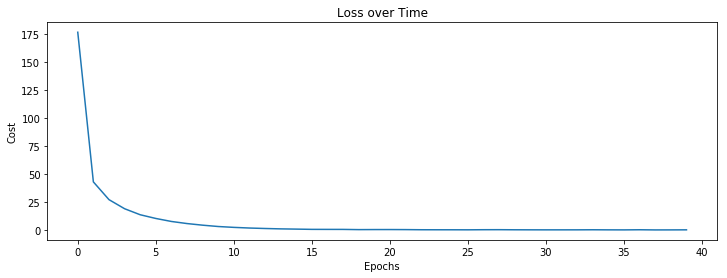

In [15]:
# Visualize loss over time
costs_df = pd.Series(data=costs)
costs_df.plot(figsize=(12, 4), title='Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [16]:
# Test model
correct_predictions = tf.cast( tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)), "float")

In [17]:
# use the tf.reduce_mean function in order to grab the mean of the elements across the tensor.
accuracy = tf.reduce_mean(correct_predictions)

# evaluate accuracy
print("Accuracy is:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

Accuracy is: 0.9592


95.9% is pretty good. But there are few things we could do to improve the accuracy.
- Increase the training epochs 
- Try making a deeper model.re because that will take a very long time to run!